In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Network():
    
    def __init__(self, layers, weights = None, biases = None):
        self.num_layers = len(layers)
        self.layers = layers
        if weights and biases:
            self.weights = weights
            self.biases = biases
        else:
            # initializes the weights using Xavier initialization
            self.weights = [np.random.uniform(-1, 1, (r, c))/np.sqrt(c) for r, c in zip(self.layers[1:], self.layers[:-1])]
            self.biases = [np.random.uniform(-1, 1, (r, 1)) for r in self.layers[1:]]
            
        # momentum initialization  
        self.v_delta_b = [np.zeros(b.shape) for b in self.biases]
        self.v_delta_w = [np.zeros(w.shape) for w in self.weights]
        
        # RMS propagation initialization
        self.s_delta_b = [np.zeros(b.shape) for b in self.biases]
        self.s_delta_w = [np.zeros(w.shape) for w in self.weights]
        
    def feedforward(self, a):
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            a = np.tanh(np.dot(w, a)+b)
        a = self.softmax(np.dot(self.weights[-1], a)+self.biases[-1])
#         a = self.sigmoids(np.dot(self.weights[-1], a)+self.biases[-1])
        return a
                
    def sigmoid(self, z):
        return 1.0/(1+np.exp(-z))
    
    def softmax(self, z):
        s  = np.squeeze(np.sum(np.exp(z), axis = 0))
        return np.exp(z)/s
    
    def fit(self, X_train, y_train, epochs, learning_rate, mini_batch_size, X_test, y_test, lmbda = 0, beta1 = 0, beta2 = 0, epsilon = 1e-8, print_validation_accuracy = False, print_validation_cost = False):
        
        validation_costs = []
        validation_accuracies = []
        
        for i in range(epochs):
            
            #shuffling the training data
            permutation = list(np.random.permutation(X_train.shape[0]))
            X_shuffled_train = X_train[permutation, :]
            y_shuffled_train = y_train[permutation, :]
            
            #creating mini-batches
            mini_batches_X = [X_shuffled_train[j:j+mini_batch_size] for j in range(0, len(X_train), mini_batch_size)]
            mini_batches_y = [y_shuffled_train[j:j+mini_batch_size] for j in range(0, len(X_train), mini_batch_size)]
            
            for mini_batch_X, mini_batch_y in zip(mini_batches_X, mini_batches_y):
                self.update_mini_batch(mini_batch_X, mini_batch_y, len(X_train), mini_batch_size, learning_rate, lmbda, beta1, beta2, epsilon)
            
            validation_accuracy, validation_cost = self.evaluate(X_test, y_test)
            print("Epoch {}/{} done: {}/{}".format(i+1, epochs, validation_accuracy, len(X_test)))
            
            if print_validation_accuracy:
                validation_accuracies.append(validation_accuracy/len(X_test))
            if print_validation_cost:
                validation_costs.append(validation_cost)
                
        if print_validation_accuracy:
            plt.subplot(1, 2, 1)
            plt.plot(validation_accuracies)
            plt.ylabel('accuracy')
            plt.xlabel('epochs (per fives)')
            plt.show()
        if print_validation_cost:
            plt.subplot(1, 2, 2)
            plt.plot(validation_costs)
            plt.ylabel('cost')
            plt.xlabel('epochs (per fives)')
            plt.show()
                
    def update_mini_batch(self, mini_batch_X, mini_batch_y, training_data_size, mini_batch_size, learning_rate, lmbda, beta1, beta2, epsilon):

        # get updated values for v_delta and s_delta to update the network's learnable parameters
        self.backprob(mini_batch_X.T, mini_batch_y.T, mini_batch_size, beta1, beta2)
        
        self.biases = [b-(learning_rate/mini_batch_size)*(vdb/np.sqrt(sdb+epsilon)) 
                        for b, vdb, sdb in zip(self.biases, self.v_delta_b, self.s_delta_b)]
        self.weights = [(1-(learning_rate*lmbda/training_data_size))*w-(learning_rate/mini_batch_size)*(vdw/np.sqrt(sdw+epsilon)) 
                        for w, vdw, sdw in zip(self.weights, self.v_delta_w, self.s_delta_w)]
        
    def backprob(self, X, y, mini_batch_size, beta1, beta2):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        #forward pass
        Z1 = np.dot(self.weights[0], X)+self.biases[0]
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.weights[1], A1)+self.biases[1]
        A2 = self.softmax(Z2)
#         A2 = self.sigmoid(Z2)
        
        #backward pass
        dZ2 = A2-y
        
        nabla_b[-1] = np.sum(dZ2, axis = 1, keepdims = True)/mini_batch_size
        self.v_delta_b[-1] = beta1*self.v_delta_b[-1]+(1-beta1)*nabla_b[-1] #momentum
        self.s_delta_b[-1] = beta2*self.s_delta_b[-1]+(1-beta2)*(nabla_b[-1]**2) #RMS
        
        nabla_w[-1] = np.dot(dZ2, A1.T)/mini_batch_size
        self.v_delta_w[-1] = beta1*self.v_delta_w[-1]+(1-beta1)*nabla_w[-1]
        self.s_delta_w[-1] = beta2*self.s_delta_w[-1]+(1-beta2)*(nabla_w[-1]**2)
        
        dZ1 = np.dot(self.weights[-1].T, dZ2)*(1-np.power(np.tanh(Z1), 2))
        
        nabla_b[-2] = np.sum(dZ1, axis = 1, keepdims = True)/mini_batch_size
        self.v_delta_b[-2] = beta1*self.v_delta_b[-2]+(1-beta1)*nabla_b[-2]
        self.s_delta_b[-2] = beta2*self.s_delta_b[-2]+(1-beta2)*(nabla_b[-2]**2)
        
        nabla_w[-2] = np.dot(dZ1, X.T)/mini_batch_size
        self.v_delta_w[-2] = beta1*self.v_delta_w[-2]+(1-beta1)*nabla_w[-2]
        self.s_delta_w[-2] = beta2*self.s_delta_w[-2]+(1-beta2)*(nabla_w[-2]**2)
            
    def evaluate(self, X_test, y_test):
        Z1 = np.dot(self.weights[0], X_test.T)+self.biases[0]
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.weights[1], A1)+self.biases[1]
        A2 = self.softmax(Z2)
#         A2 = self.sigmoid(Z2)

        res = np.argmax(A2, axis = 0)
        cost = -np.sum(y_test.T*np.log(A2)+(1-y_test.T)*np.log(1-A2))/len(X_test)
        validation_accuracy = sum(int(y_hat==y) for y_hat, y in zip(res, np.argmax(y_test.T, axis = 0)))
        return (validation_accuracy, cost)
    
    def predict(self, X):
        res = self.feedforward(X.reshape((self.layers[0], 1)))
        print(res)
        return np.argmax(res, axis = 0)
         
        

In [2]:
import tensorflow.keras as keras

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_train = X_train/255
X_test = X_test/255

In [5]:
X_train.resize(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

In [6]:
X_test.resize(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [7]:
y_train_changed = []
for i in range(y_train.shape[0]):
    y = [0]*10
    y[y_train[i]] = 1
    y_train_changed.append(y)
y_train = np.array(y_train_changed)

In [8]:
y_test_changed = []
for i in range(y_test.shape[0]):
    y = [0]*10
    y[y_test[i]] = 1
    y_test_changed.append(y)
y_test = np.array(y_test_changed)

In [ ]:
print(y_train.shape)

In [9]:
nn = Network([784, 30, 10])
nn.fit(X_train, y_train, 30, 0.01, 10, X_test, y_test, lmbda = 4, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, print_validation_accuracy = False, print_validation_cost = False)

Epoch 1/30 done: 9495/10000
Epoch 2/30 done: 9549/10000
Epoch 3/30 done: 9551/10000
Epoch 4/30 done: 9607/10000
Epoch 5/30 done: 9646/10000
Epoch 6/30 done: 9619/10000
Epoch 7/30 done: 9628/10000
Epoch 8/30 done: 9625/10000
Epoch 9/30 done: 9659/10000
Epoch 10/30 done: 9576/10000
Epoch 11/30 done: 9622/10000
Epoch 12/30 done: 9614/10000
Epoch 13/30 done: 9601/10000
Epoch 14/30 done: 9627/10000
Epoch 15/30 done: 9610/10000
Epoch 16/30 done: 9626/10000
Epoch 17/30 done: 9589/10000
Epoch 18/30 done: 9596/10000
Epoch 19/30 done: 9626/10000
Epoch 20/30 done: 9627/10000
Epoch 21/30 done: 9610/10000
Epoch 22/30 done: 9599/10000
Epoch 23/30 done: 9606/10000
Epoch 24/30 done: 9606/10000
Epoch 25/30 done: 9569/10000
Epoch 26/30 done: 9600/10000
Epoch 27/30 done: 9599/10000
Epoch 28/30 done: 9597/10000
Epoch 29/30 done: 9607/10000
Epoch 30/30 done: 9585/10000


In [ ]:
import pickle

pickle.dump(nn.weights, open("weights/weights-0.01-eta-10-mbs-6-lmbda-default_adam-96.34-val_acc.pickle", "wb"))
pickle.dump(nn.biases, open("biases/biases-0.01-eta-10-mbs-6-lmbda-default_adam-96.34-val_acc.pickle", "wb"))

In [11]:
import pickle

weights_trained = pickle.load(open("weights/weights-0.01-eta-10-mbs-6-lmbda-default_adam-96.34-val_acc.pickle", "rb"))
biases_trained = pickle.load(open("biases/biases-0.01-eta-10-mbs-6-lmbda-default_adam-96.34-val_acc.pickle", "rb"))
nn_trained = Network([784, 30, 10], weights = weights_trained, biases = biases_trained)

label:  [0 0 0 0 0 0 1 0 0 0]
[[6.39317327e-06]
 [4.39561771e-09]
 [8.81346605e-06]
 [1.99474529e-07]
 [7.68780073e-04]
 [2.98163676e-05]
 [9.96421174e-01]
 [3.48072202e-08]
 [2.76298107e-03]
 [1.80355231e-06]]
prediction:  [6]


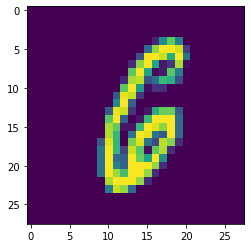

In [12]:
index = 1212
img = X_test[index].reshape((28, 28))
print("label: ", y_test[index])
plt.imshow(img)#, cmap = "binary")
print("prediction: ", nn_trained.predict(img))